### 이 코드는 GWD의 학습된 모델을 불러와서 test 데이터로 predict을 해보고, 인터넷으로 다운받은 데이터로 predict을 해보는 노트북 입니다.

2020/08/06 혜주 공부

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="{}".format(1) # gpu idx

In [2]:
import warnings
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

In [3]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512

TEST_PATH = './test/'
TEST2_PATH = './test2/'
SC_FACTOR = int(1024 / IMG_WIDTH)

warnings.filterwarnings('ignore')
seed = 42
random.seed = seed
np.random.seed = seed

In [4]:
test_ids = os.listdir(TEST_PATH)    # test 데이터
test2_ids = os.listdir(TEST2_PATH)  # 새로 다운받은 데이터

test2_ids = random.sample(test2_ids, 10)

In [5]:
test_ids

['aac893a91.jpg',
 '2fd875eaa.jpg',
 '348a992bb.jpg',
 '51f1be19e.jpg',
 '51b3e36ab.jpg',
 'cc3532ff6.jpg',
 'f5a1f0358.jpg',
 'cb8d261a3.jpg',
 '53f253011.jpg',
 '796707dd7.jpg']

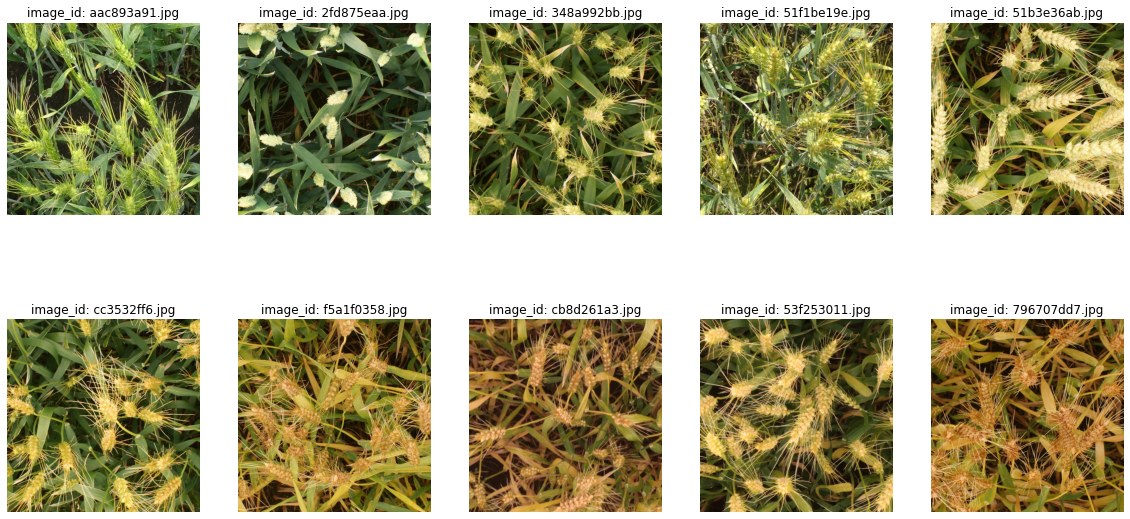

In [6]:
f, ax = plt.subplots(2,5, figsize=(20, 10))
for i, image_id in enumerate(test_ids):
    image_path = os.path.join(TEST_PATH, f'{image_id}')
    image = Image.open(image_path)        

    ax[i//5, i%5].imshow(image) 
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(f"image_id: {image_id}")
    
plt.show()

In [7]:
test2_ids

['39.wheat-blast-hero.jpg',
 '50.0525_septoria_free.jpg',
 '28.banner_wheat_1_690px.jpg',
 '23.xm997-1_480x480.jpg',
 '22.ca_0410nid_wheat_online5.jpg',
 '48.great-falls-wheat.jpg',
 '42.inform-5.kz_.jpg',
 '40.red-wheat_photo-cred-adobe-stock_e.jpg',
 '36.news-article-large_0.jpg',
 '87.montana-wheat-golden-triangle-family-farms-square.jpg']

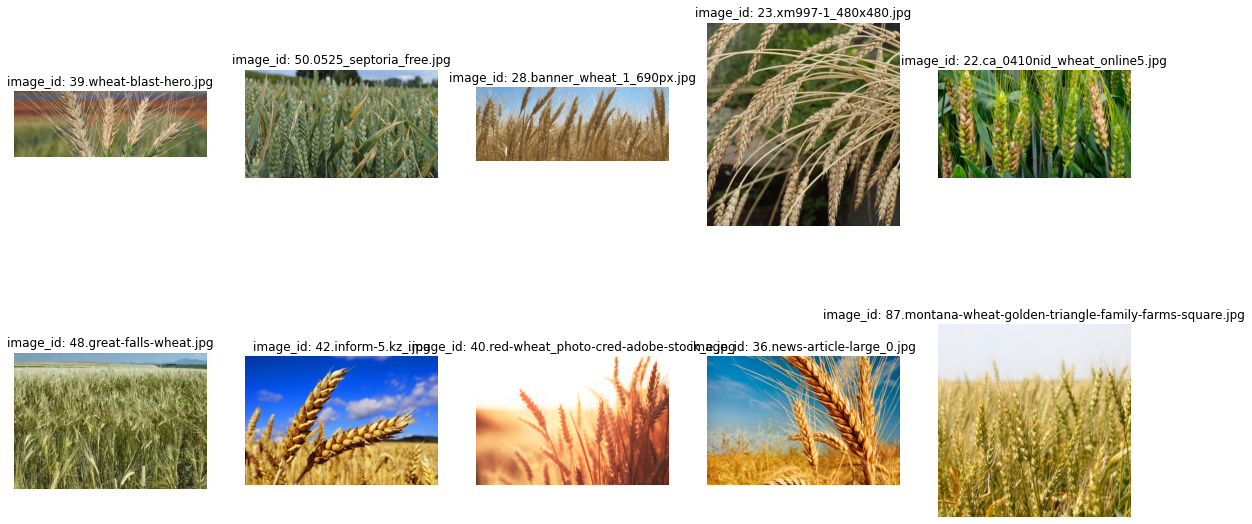

In [8]:
f, ax = plt.subplots(2,5, figsize=(20, 10))
for i, image_id in enumerate(test2_ids):
    image_path = os.path.join(TEST2_PATH, f'{image_id}')
    image = Image.open(image_path)        

    ax[i//5, i%5].imshow(image) 
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(f"image_id: {image_id}")
    
plt.show()

### Get and resize test images

In [9]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
sizes_test = list()
print('Getting and resizing test images...')

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images...


In [10]:
# Get and resize test images
X_test2 = np.zeros((len(test2_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
sizes_test = list()
print('Getting and resizing test images...')

for n, id_ in tqdm(enumerate(test2_ids), total=len(test2_ids)):
    path = TEST2_PATH + id_
    img = imread(path)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test2[n] = img

Getting and resizing test images...


In [11]:
# Get and resize test images
X_test3 = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
sizes_test = list()
print('Getting and resizing test images...')

for n in range(1):
    path = './fig-2.jpg' #TEST2_PATH + id_
    img = imread(path)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test3[n] = img

Getting and resizing test images...


In [12]:
X_test3.shape

(1, 512, 512, 3)

In [13]:
X_test.shape, X_test2.shape

((10, 512, 512, 3), (10, 512, 512, 3))

### Load model

* load_model이 안되어 다시 네트워크를 쌓고 weight만 불러옴. --> 맨 아래 stackoverflow 링크 참조

In [14]:
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras import backend as K

Using TensorFlow backend.


In [15]:
#Credits to : https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63044

def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred):

    tresholds = [0.5 + (i * 0.05)  for i in range(5)]  #tresholds = [0.5, 0.55, 0.6, 0.65, 0.7]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [16]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)  # rescale inputs

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[competitionMetric2])
model.summary()

W0812 23:35:22.404560 140334523787072 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 23:35:22.416244 140334523787072 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 23:35:22.421027 140334523787072 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0812 23:35:22.428761 140334523787072 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512, 512, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

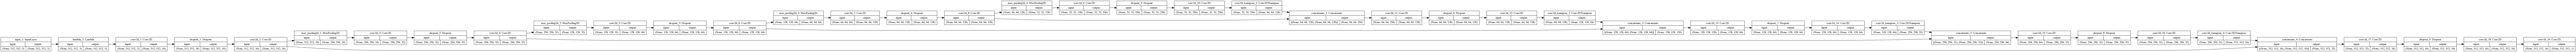

In [17]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, rankdir='LR')
from IPython.display import Image
Image('model.png')

In [15]:
#from keras.models import load_model

In [16]:
#fn_model = './model_200806.h5'

In [17]:
# load model
#model = load_model(fn_model)

In [18]:
model.load_weights('model_200806.h5')

In [19]:
THRESH = 0.65

preds = model.predict(X_test)[:, :, :, 0]
masked_preds = preds > THRESH

In [20]:
preds.shape, masked_preds.shape

((10, 512, 512), (10, 512, 512))

### Test data로 Predict

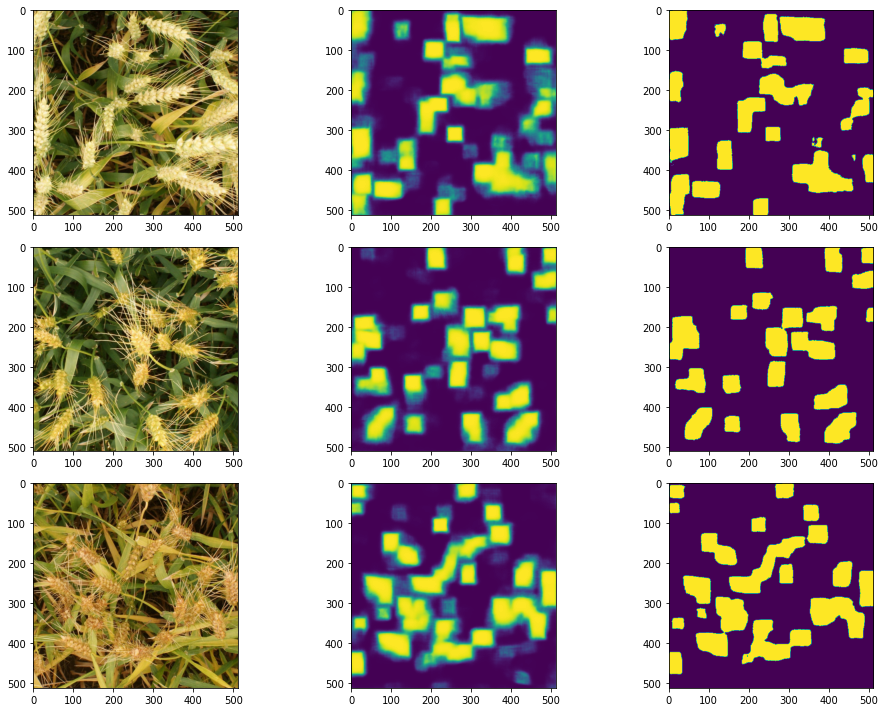

In [21]:
n_rows = 3
f, ax = plt.subplots(n_rows, 3, figsize=(14, 10))

for j, idx in enumerate([4,5,6]):
    for k, kind in enumerate(['original', 'pred', 'masked_pred']):
        if kind == 'original':
            img = X_test[idx]
        elif kind == 'pred':
            img = preds[idx]
        elif kind == 'masked_pred':
            masked_pred = preds[idx] > THRESH
            img = masked_pred
        ax[j, k].imshow(img)

plt.tight_layout()

### 인터넷으로 가져온 사진으로 Predict

In [66]:
THRESH = 0.65

preds = model.predict(X_test2)[:, :, :, 0]
masked_preds = preds > THRESH

In [67]:
preds.shape, masked_preds.shape

((10, 512, 512), (10, 512, 512))

In [70]:
preds[0]

array([[0.47179005, 0.49515703, 0.47605994, ..., 0.5464323 , 0.5162793 ,
        0.48636585],
       [0.47445738, 0.49539587, 0.51398   , ..., 0.62279   , 0.5955431 ,
        0.4983694 ],
       [0.47004154, 0.50522864, 0.50910926, ..., 0.65339345, 0.61579907,
        0.5309546 ],
       ...,
       [0.04162523, 0.02525789, 0.01666379, ..., 0.01659742, 0.01692191,
        0.03384435],
       [0.0589579 , 0.03339911, 0.02124667, ..., 0.0227668 , 0.02418318,
        0.04931799],
       [0.12693688, 0.05997178, 0.04545122, ..., 0.03745243, 0.04657981,
        0.08670461]], dtype=float32)

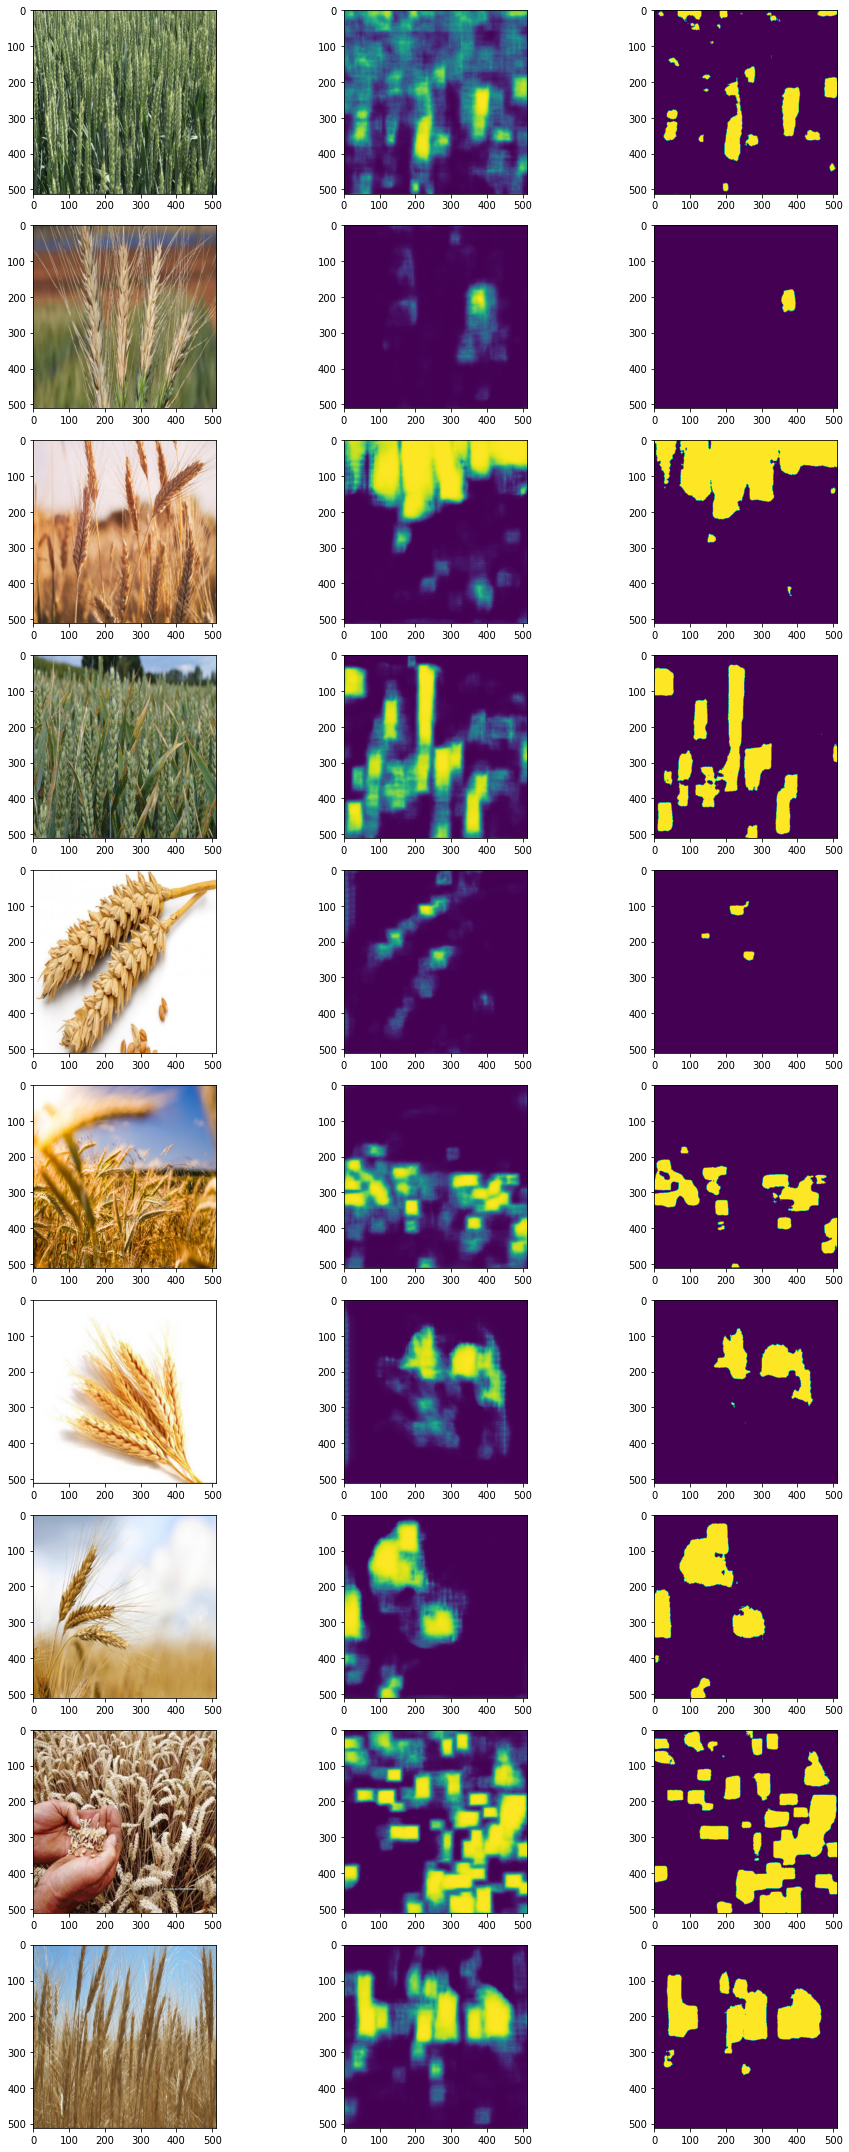

In [53]:
n_rows = 10
f, ax = plt.subplots(n_rows, 3, figsize=(14, 30))

for j, idx in enumerate([0,1,2,3,4,5,6,7,8,9]):
    #print(j, idx)
    for k, kind in enumerate(['original', 'pred', 'masked_pred']):
        if kind == 'original':
            img = X_test2[idx]
        elif kind == 'pred':
            img = preds[idx]
        elif kind == 'masked_pred':
            masked_pred = preds[idx] > THRESH
            img = masked_pred
        ax[j, k].imshow(img)

plt.tight_layout()

In [88]:
THRESH = 0.65

preds = model.predict(X_test3)[:, :, :, 0]
masked_preds = preds > THRESH

In [89]:
preds.shape, masked_preds.shape

((1, 512, 512), (1, 512, 512))

In [90]:
preds[0].shape

(512, 512)

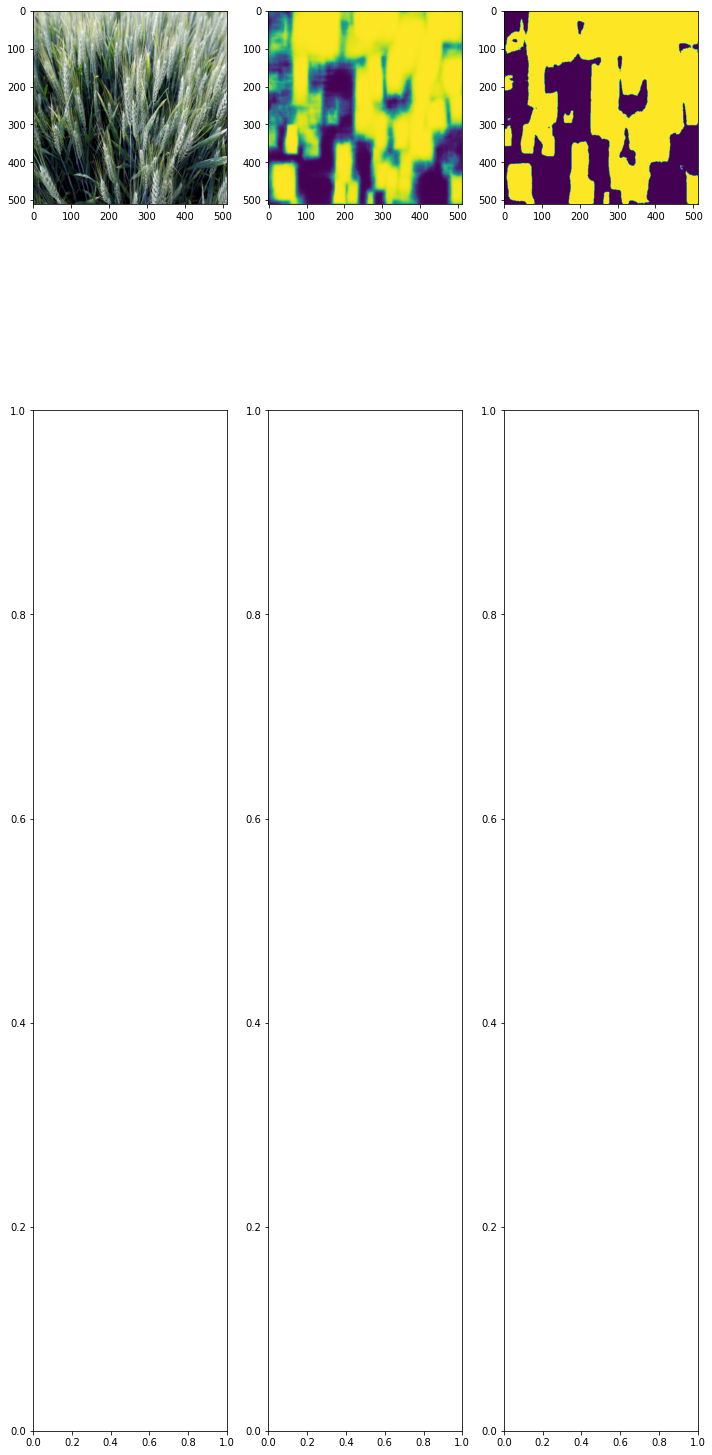

In [91]:
f, ax = plt.subplots(2, 3, figsize=(10, 26))

for k, kind in enumerate(['original', 'pred', 'masked_pred']):
    #print(k)
    if kind == 'original':
        img = X_test3[idx]
    elif kind == 'pred':
        img = preds[idx]
    elif kind == 'masked_pred':
        masked_pred = preds[idx] > THRESH
        img = masked_pred
    ax[0, k].imshow(img)

plt.tight_layout()

### 결론
* train과 test 이미지는 모두 위에서 내려다보는 각도로 밀을 찍은 사진이다. 그리고 사진 안에 밀머리가 20~60개 정도의 분포를 갖도록 crop 되어 있다.
* 내가 인터넷으로 긁어온 이미지들은 사진의 size만 512, 512로 맞춘 것이지 각도나 밀의 크기가 제각각이라 잘 못맞추는 경향을 보인다.
* kaggle에서 제공한 데이터 셋과 비슷한 밀 이미지 데이터는 찾을 수 없었다.
* 인터넷으로 가져온 사진을 비슷한 방식으로 전처리 해볼 수 있는 방법을 찾아보았지만, 사진의 각도부터 달라 불가능할 것으로 예상.

### cf. 밀 데이터 셋을 만든 과정

* model.load가 안될때
https://stackoverflow.com/questions/53212672/read-only-mode-in-keras
* kaggle GWD 데이터 셋을 만들어낸 방법
https://arxiv.org/abs/2005.02162

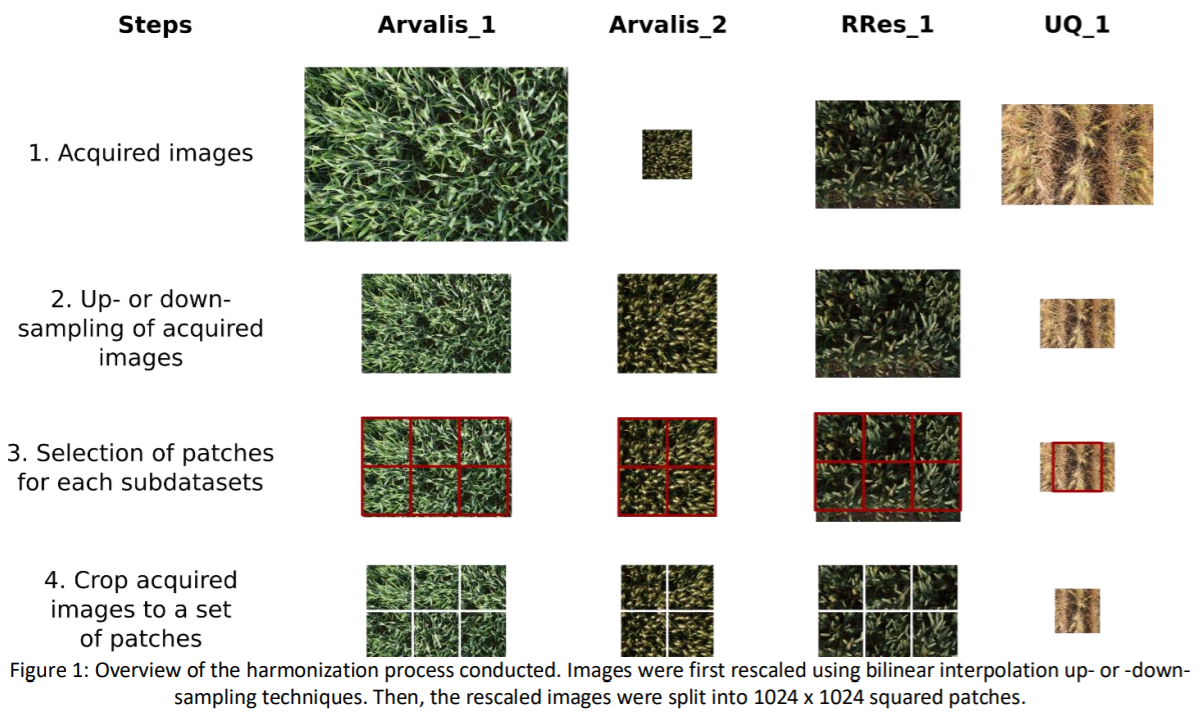